# Packages

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway, stats, zscore
from dtaidistance import dtw
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.decomposition import PCA
import time
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.mixture import BayesianGaussianMixture
import tensorflow as tf
import tensorboard as tb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from keras import regularizers
from keras.losses import Huber

# Target 1

In [120]:
data = pd.read_csv("edin_unit_data_v3.csv")
data = data.drop([data.columns[0]], axis=1) # drop the first column
data

,individual_id,timestamp,date,day_of_week,hour_of_day,department,spend,at_risk_event,at_risk_behaviour_window
0,1,59:40.0,09/01/2023,Monday,11.994438,ops,2.10,False,NaN
1,1,10:02.9,11/01/2023,Wednesday,9.167461,ops,4.45,False,NaN
2,1,51:48.7,12/01/2023,Thursday,8.863522,ops,3.94,False,NaN
3,1,44:15.0,12/01/2023,Thursday,10.737514,ops,2.72,False,NaN
4,1,30:58.9,12/01/2023,Thursday,13.516375,ops,1.50,False,NaN
...,...,...,...,...,...,...,...,...,...
105272,2184,20:57.3,20/04/2023,Thursday,12.349245,finance,8.91,False,NaN
105273,2184,12:27.8,21/04/2023,Friday,10.207728,finance,20.24,False,NaN
105274,2184,24:52.3,24/04/2023,Monday,17.414535,finance,12.25,False,NaN
105275,2185,50:15.0,08/02/2023,Wednesday,12.837514,investor_relations,15.68,False,NaN


# Explanatory Data Analysis

In [121]:
print(data.info()) # only 'at_risk_behaviour_window' with missing values
print(data.describe()) # exist outliers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105277 entries, 0 to 105276
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   individual_id             105277 non-null  int64  
 1   timestamp                 105277 non-null  object 
 2   date                      105277 non-null  object 
 3   day_of_week               105277 non-null  object 
 4   hour_of_day               105277 non-null  float64
 5   department                105277 non-null  object 
 6   spend                     105277 non-null  float64
 7   at_risk_event             105277 non-null  bool   
 8   at_risk_behaviour_window  4048 non-null    float64
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 6.5+ MB
None
       individual_id    hour_of_day          spend  at_risk_behaviour_window
count  105277.000000  105277.000000  105277.000000               4048.000000
mean     1106.065712      13.033767      10.

In [122]:
# Calculate the number of true
true_count = data[data['at_risk_event'] == True].shape[0]

# Calculate the ratio of risk in data
total_rows = data.shape[0]
true_percentage = (true_count / total_rows) * 100

print(f"The ratio of risk events is : {true_percentage:.2f}%")

The ratio of risk events is : 2.63%


In [123]:
# Calculate the data size descriptive information
records_per_individual = data.groupby('individual_id').size().describe()
print(records_per_individual) # the data size of each person is very distinct

count    2185.000000
mean       48.181693
std        40.596902
min         1.000000
25%        17.000000
50%        37.000000
75%        68.000000
max       269.000000
dtype: float64


We can find the distribution of spend is right-skewed, so we need to transform it using log. `log_spend` can be used for modeling later. And the distribution of `hour_of_day` is likely to be three normal distributions.

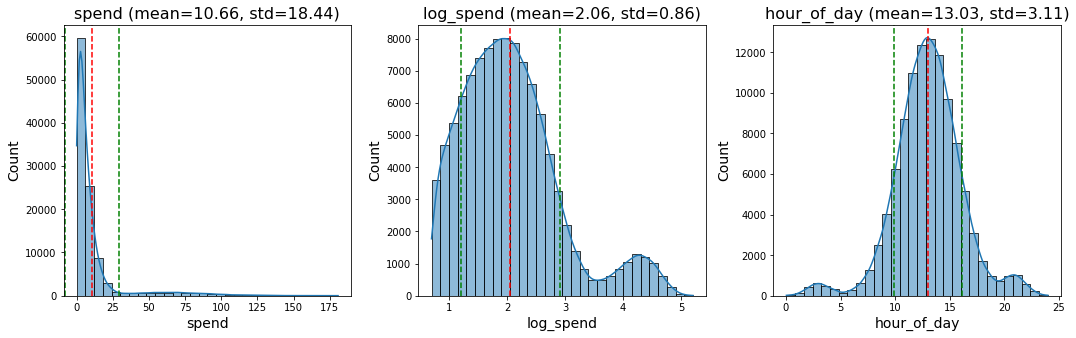

In [124]:
# add log_spend variable
data['log_spend'] = np.log1p(data['spend']+1) # Add 1 to avoid taking the log of 0
num_cols = ['spend', 'log_spend', 'hour_of_day']
fig, axes = plt.subplots(1, len(num_cols), figsize=(15, 5))

for i, col in enumerate(num_cols):
    sns.histplot(data[col], bins=30, kde=True, ax=axes[i])
    mean = data[col].mean()
    std = data[col].std()
    axes[i].set_title(f'{col} (mean={mean:.2f}, std={std:.2f})',fontsize=16)
    axes[i].axvline(mean, color='r', linestyle='--')
    axes[i].axvline(mean + std, color='g', linestyle='--')
    axes[i].axvline(mean - std, color='g', linestyle='--')
    axes[i].set_ylabel('Count',fontsize=14)
    axes[i].set_xlabel(col,fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

We then do a simple and initial feature transformation for time variables:

- round `hour_of_day` to `hour` for plotting and testing
- extract the `month` from the date
- extract the `minute` and `second` from the timestampe

In [125]:
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y') # transform to time format
data['hour'] = data['hour_of_day'].round().astype(int) # round hour into int for plotting 
data['month'] = data['date'].dt.month # extract month

# Converts timestamp column time format
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%M:%S.%f')
data['minute'] = data['timestamp'].dt.minute
data['second'] = data['timestamp'].dt.second
data = data.drop('timestamp', axis=1) # has converted timestamp into minute and second
data.head()

,individual_id,date,day_of_week,hour_of_day,department,spend,at_risk_event,at_risk_behaviour_window,log_spend,hour,month,minute,second
0,1,2023-01-09,Monday,11.994438,ops,2.10,False,NaN,1.410987,12,1,59,40
1,1,2023-01-11,Wednesday,9.167461,ops,4.45,False,NaN,1.864080,9,1,10,2
2,1,2023-01-12,Thursday,8.863522,ops,3.94,False,NaN,1.781709,9,1,51,48
3,1,2023-01-12,Thursday,10.737514,ops,2.72,False,NaN,1.551809,11,1,44,15
4,1,2023-01-12,Thursday,13.516375,ops,1.50,False,NaN,1.252763,14,1,30,58


Now, we can test if each of the categorical variables is independent of the target `at_risk_event` by using chi2 test.

In [126]:
# List of categorical variables
categorical_vars = ['month', 'day_of_week', 'hour', 'minute', 'second', 'department']
# Target variable
target_var = 'at_risk_event'
# DataFrame to store Chi-squared test results
chi2_results = pd.DataFrame(columns=['Variable', 'Chi-squared', 'P-value', 'DoF'])

# Loop through each categorical variable to test with the target variable
for var in categorical_vars:
    crosstab = pd.crosstab(data[var], data[target_var])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    if p < 1e-308:
        p_value_display = "<1e-308"
    else:
        p_value_display = f"{p:.2e}"
    row = pd.DataFrame({
        'Variable': [var],
        'Chi-squared': [chi2],
        'P-value': [p_value_display],
        'DoF': [dof]
    })
    chi2_results = pd.concat([chi2_results, row], ignore_index=True)

# Display results
chi2_results

,Variable,Chi-squared,P-value,DoF
0,month,235.710175,8.06e-51,3
1,day_of_week,12111.005014,<1e-308,6
2,hour,3383.947825,<1e-308,24
3,minute,57.434736,5.33e-01,59
4,second,68.173483,1.94e-01,59
5,department,178.165740,7.10e-28,19


We can find that variables `minute` and `second` are independent of our target variable `at_risk_event`, other varialbes are all dependent in some ways. Thus, we may extract more information to find their relationship with the target later.

Next, for the relation between categorical and numerical variables, we did `ANOVA (Analysis of Variance)`, a higher F-value indicates a larger between-group variation relative to within-group variation, suggesting significant differences in the numerical variable `spend` between different categories. 

In [127]:
# Data for ANOVA results
anova_results = pd.DataFrame(columns=['Category', 'F-Value', 'P-Value'])
categorical_vars.append(target_var)
# Loop through each category and interact with 'at_risk_event'
for category in categorical_vars:
    # Group data by the new interaction term and collect 'spend'
    grouped_data = [group['spend'].values for name, group in data.groupby(category)]
    # Perform ANOVA across these groups
    f_value, p_value = f_oneway(*grouped_data)
    if p_value < 1e-308:
        p_value_display = "<1e-308"
    else:
        p_value_display = f"{p_value:.2e}"
    
    # Store results
    row = pd.DataFrame({
        'Category': [category],
        'F-Value': [f_value],
        'P-Value': [p_value_display]
    })
    anova_results = pd.concat([anova_results, row], ignore_index=True)

# Display ANOVA results
anova_results

,Category,F-Value,P-Value
0,month,53.432501,1.68e-34
1,day_of_week,205.259925,2.46e-261
2,hour,164.157356,<1e-308
3,minute,0.932107,6.24e-01
4,second,0.793830,8.74e-01
5,department,57.879662,4.20e-220
6,at_risk_event,1893.345676,<1e-308


We can find that the P-values are all very small apart from the minute and second variables. This means that the categorical variables (such as month, day of the week, hour, department, whether it's a risk event, etc.) have a significant impact on spending, and they are likely important predictors. So we need to find out more about them with spending using graphs.

In [128]:
data = data.drop(['minute','second'], axis=1) # minute and second are useless

We first explore the variable `spend` among risk and non-risk groups as a start point.

We will use the median statistic for spending because it is more robust to the outliers.

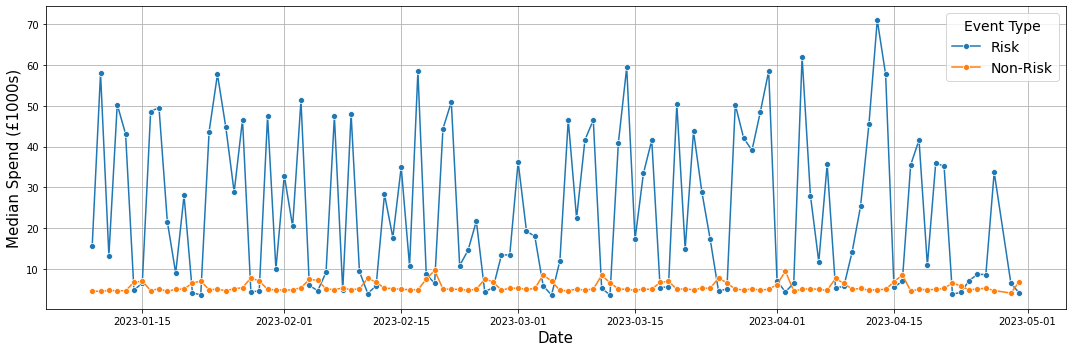

In [129]:
# Calculate the median spend per day for risky and non-risky events
median_spend_per_day = data.groupby(['date', 'at_risk_event']).agg({
    'spend': 'median'
}).reset_index()

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=median_spend_per_day[median_spend_per_day['at_risk_event'] == True], x='date', y='spend', marker='o', label='Risk', ax=ax)
sns.lineplot(data=median_spend_per_day[median_spend_per_day['at_risk_event'] == False], x='date', y='spend', marker='o', label='Non-Risk', ax=ax)

# ax.set_title('Median Spend per Day for Risk and Non-Risk Events',fontsize=18)
ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Median Spend (£1000s)',fontsize=15)
ax.legend(title='Event Type',fontsize=14,title_fontsize=14)
ax.grid(True)
plt.tight_layout()
plt.show()

This is the plot of the median spend per day group by risk/non risk event, overall,  we can say the median spend is much higher in the risky event than non-risky event. However, there also exist some cases which are risky but have lower median spends than non-risk events. Therefore, it is not enough to consider only the variable `spend` for identifying risky events.

Therefore, let us plot more graphs to find more about `day_of_week`, `hour` and `department`.

The first graph is used to show the relation between `day_of_week` and **event count & median、mean spend** by risky status. The left y-axis shows count, and the right y-axis shows spending.

From the bar chart, we can find that there is a clear difference in the number and proportion of risk events during the weekdays and weekends. For risk events, both the mean and median spending dropped significantly on weekends. However, for non-risk events, the median spending was not much different between weekends and midweek, but the mean spending increased significantly on weekends.

The above analysis tells us that：
- we may be able to separate midweek days and weekend days into a new variable: 1(weekends) 0(weekdays)

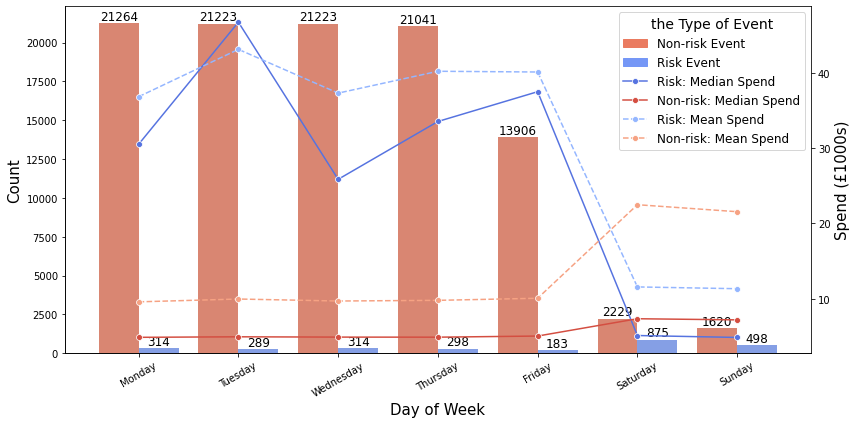

In [130]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['day_of_week'] = pd.Categorical(data['day_of_week'], categories=days_order, ordered=True)

# set the colours of the bar and line
true_color_light = sns.color_palette("coolwarm", 10)[1]
true_color_dark = sns.color_palette("coolwarm", 10)[0]
false_color_light = sns.color_palette("coolwarm", 10)[8]
false_color_dark = sns.color_palette("coolwarm", 10)[9]
mean_color_true = sns.color_palette("coolwarm", 10)[2]
mean_color_false = sns.color_palette("coolwarm", 10)[7]

g = sns.catplot(x='day_of_week', hue='at_risk_event', data=data, kind='count', height=6, aspect=2, palette=[false_color_light, true_color_light], legend=False)

median_spend_true = data[data['at_risk_event'] == True].groupby('day_of_week')['spend'].median()
median_spend_false = data[data['at_risk_event'] == False].groupby('day_of_week')['spend'].median()
mean_spend_true = data[data['at_risk_event'] == True].groupby('day_of_week')['spend'].mean()
mean_spend_false = data[data['at_risk_event'] == False].groupby('day_of_week')['spend'].mean()

# add median spend lines
ax = g.axes.flat[0]
ax2 = ax.twinx()
line1 = sns.lineplot(x=median_spend_true.index, y=median_spend_true.values, ax=ax2, marker='o', color=true_color_dark, label='Risk: Median Spend')
line2 = sns.lineplot(x=median_spend_false.index, y=median_spend_false.values, ax=ax2, marker='o', color=false_color_dark, label='Non-risk: Median Spend')
line3 = sns.lineplot(x=mean_spend_true.index, y=mean_spend_true.values, ax=ax2, marker='o', linestyle='--', color=mean_color_true, label='Risk: Mean Spend')
line4 = sns.lineplot(x=mean_spend_false.index, y=mean_spend_false.values, ax=ax2, marker='o', linestyle='--', color=mean_color_false, label='Non-risk: Mean Spend')
ax2.set_ylabel('Spend (£1000s)',fontsize=15)
for c in ax.containers:
    labels = [f'{int(v.get_height())}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge', fontsize=12)
handles1 = [Patch(color=false_color_light, label='Non-risk Event'), Patch(color=true_color_light, label='Risk Event')]
labels1 = ['Non-risk Event', 'Risk Event']
handles2, labels2 = ax2.get_legend_handles_labels()
# combine legends
combined_handles = handles1 + handles2
combined_labels = labels1 + labels2
ax2.legend(combined_handles, combined_labels, loc='upper right', title='Event Type and Spend', fontsize=10)
ax2.legend(combined_handles, combined_labels, loc='upper right', title='the Type of Event', fontsize=12,title_fontsize=14)
g.set_axis_labels('Day of Week', 'Count',fontsize=15)
# g.fig.suptitle('Distribution of Events by Day of Week and Risk Status with Median and Mean Spend', fontsize=20)
g.set_xticklabels(rotation=30)

plt.tight_layout()
plt.show()

In [131]:
# add variable to distinguish weekdays and weekends
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
data

,individual_id,date,day_of_week,hour_of_day,department,spend,at_risk_event,at_risk_behaviour_window,log_spend,hour,month,is_weekend
0,1,2023-01-09,Monday,11.994438,ops,2.10,False,NaN,1.410987,12,1,0
1,1,2023-01-11,Wednesday,9.167461,ops,4.45,False,NaN,1.864080,9,1,0
2,1,2023-01-12,Thursday,8.863522,ops,3.94,False,NaN,1.781709,9,1,0
3,1,2023-01-12,Thursday,10.737514,ops,2.72,False,NaN,1.551809,11,1,0
4,1,2023-01-12,Thursday,13.516375,ops,1.50,False,NaN,1.252763,14,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
105272,2184,2023-04-20,Thursday,12.349245,finance,8.91,False,NaN,2.389680,12,4,0
105273,2184,2023-04-21,Friday,10.207728,finance,20.24,False,NaN,3.101892,10,4,0
105274,2184,2023-04-24,Monday,17.414535,finance,12.25,False,NaN,2.656757,17,4,0
105275,2185,2023-02-08,Wednesday,12.837514,investor_relations,15.68,False,NaN,2.872434,13,2,0


In [132]:
# Create a time series list
grouped = data.groupby('individual_id')
timeseries = [group['log_spend'].values for name, group in grouped]

# Calculate the DTW distance matrix
distance_matrix = dtw.distance_matrix_fast(timeseries)

# Normalized distance matrix
scaler = StandardScaler()
distance_matrix_scaled = scaler.fit_transform(distance_matrix)

# Try different clustering numbers and calculate the profile coefficient
silhouette_scores = []
for n_clusters in range(2, 11):  
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(distance_matrix_scaled)
    score = silhouette_score(distance_matrix_scaled, clusters)
    silhouette_scores.append(score)

# Find the best number of cluster
best_n_clusters = range(2, 11)[np.argmax(silhouette_scores)]

# Perform k-means cluster
best_kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
best_clusters = best_kmeans.fit_predict(distance_matrix_scaled)

# Create a DataFrame that contains the cluster tag
cluster_labels = pd.DataFrame({
    'individual_id': list(grouped.groups.keys()), 
    'cluster_of_spend': best_clusters
})

# Merges the clustering label DataFrame back into the original data DataFrame
data = pd.merge(data, cluster_labels, on='individual_id', how='left')

# Calculate the high spend threshold for each cluster
thresholds = {}
for cluster in data['cluster_of_spend'].unique():
    cluster_data = data[data['cluster_of_spend'] == cluster]['log_spend']
    Q3 = cluster_data.quantile(0.75)
    IQR = cluster_data.quantile(0.75) - cluster_data.quantile(0.25)
    thresholds[cluster] = Q3 + 1.5 * IQR

# Apply thresholds to flag high spends
data['is_high_spend'] = data.apply(lambda x: 1 if x['log_spend'] > thresholds[x['cluster_of_spend']] else 0, axis=1)

print("Thresholds for high spend in each cluster:", thresholds)

/Users/jade/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/jade/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/jade/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/jade/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/jade/

Thresholds for high spend in each cluster: {0: 3.828503428686178, 1: 7.613194959719642}


In [133]:
# define new interaction variables
data['weekday_high_spend'] = data.apply(lambda x: 1 if x['is_weekend'] == 0 and x['is_high_spend'] == 1 else 0, axis=1)
data['weekend_high_spend'] = data.apply(lambda x: 1 if x['is_weekend'] == 1 and x['is_high_spend'] ==  1 else 0, axis=1)
data

,individual_id,date,day_of_week,hour_of_day,department,spend,at_risk_event,at_risk_behaviour_window,log_spend,hour,month,is_weekend,cluster_of_spend,is_high_spend,weekday_high_spend,weekend_high_spend
0,1,2023-01-09,Monday,11.994438,ops,2.10,False,NaN,1.410987,12,1,0,0,0,0,0
1,1,2023-01-11,Wednesday,9.167461,ops,4.45,False,NaN,1.864080,9,1,0,0,0,0,0
2,1,2023-01-12,Thursday,8.863522,ops,3.94,False,NaN,1.781709,9,1,0,0,0,0,0
3,1,2023-01-12,Thursday,10.737514,ops,2.72,False,NaN,1.551809,11,1,0,0,0,0,0
4,1,2023-01-12,Thursday,13.516375,ops,1.50,False,NaN,1.252763,14,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105272,2184,2023-04-20,Thursday,12.349245,finance,8.91,False,NaN,2.389680,12,4,0,0,0,0,0
105273,2184,2023-04-21,Friday,10.207728,finance,20.24,False,NaN,3.101892,10,4,0,0,0,0,0
105274,2184,2023-04-24,Monday,17.414535,finance,12.25,False,NaN,2.656757,17,4,0,0,0,0,0
105275,2185,2023-02-08,Wednesday,12.837514,investor_relations,15.68,False,NaN,2.872434,13,2,0,0,0,0,0


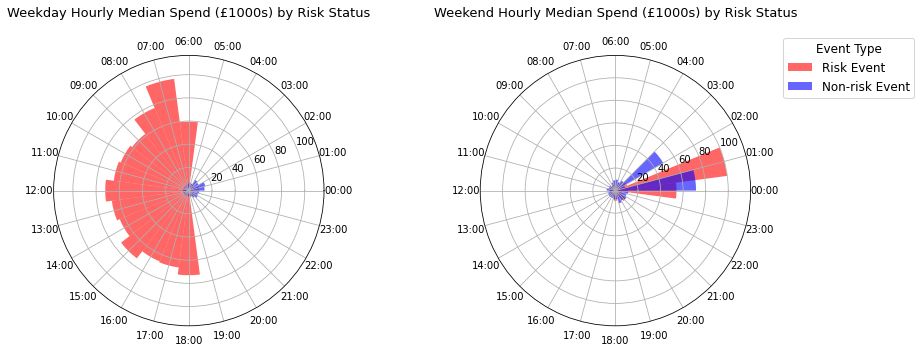

In [134]:
# Separate weekday and weekend data
weekday_data = data[data['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
weekend_data = data[data['day_of_week'].isin(['Saturday', 'Sunday'])]

# Calculate the median spending amount of risk events and non-risk events per hour for weekdays
weekday_spend_risk_median = weekday_data[weekday_data['at_risk_event'] == True].groupby('hour')['spend'].median()
weekday_spend_non_risk_median = weekday_data[weekday_data['at_risk_event'] == False].groupby('hour')['spend'].median()

# Calculate the median spending amount of risk events and non-risk events per hour for weekends
weekend_spend_risk_median = weekend_data[weekend_data['at_risk_event'] == True].groupby('hour')['spend'].median()
weekend_spend_non_risk_median = weekend_data[weekend_data['at_risk_event'] == False].groupby('hour')['spend'].median()

# Set up the plot with polar coordinates
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 5))  # Adjusted figure size here

# Convert hours to radians
theta = np.linspace(0, 2 * np.pi, 24, endpoint=False)
width = 2 * np.pi / 24

# Weekday median spend by risk status
bars1 = axes[0].bar(theta, weekday_spend_risk_median.reindex(range(24), fill_value=0), width=width, color='red', alpha=0.6, label='Risk Event')
bars2 = axes[0].bar(theta + width / 2, weekday_spend_non_risk_median.reindex(range(24), fill_value=0), width=width, color='blue', alpha=0.6, label='Non-risk Event')
axes[0].set_xticks(theta)
axes[0].set_xticklabels(['{}:00'.format(str(i).zfill(2)) for i in range(24)])
axes[0].set_title('Weekday Hourly Median Spend (£1000s) by Risk Status', pad=20, fontsize=13)
axes[0].set_ylim(0, max(weekday_spend_risk_median.max(), weekday_spend_non_risk_median.max()) * 1.2)
axes[0].grid(True)

# Weekend median spend by risk status
bars3 = axes[1].bar(theta, weekend_spend_risk_median.reindex(range(24), fill_value=0), width=width, color='red', alpha=0.6, label='Risk Event')
bars4 = axes[1].bar(theta + width / 2, weekend_spend_non_risk_median.reindex(range(24), fill_value=0), width=width, color='blue', alpha=0.6, label='Non-risk Event')
axes[1].set_xticks(theta)
axes[1].set_xticklabels(['{}:00'.format(str(i).zfill(2)) for i in range(24)])
axes[1].set_title('Weekend Hourly Median Spend (£1000s) by Risk Status', pad=20, fontsize=13)
axes[1].set_ylim(0, max(weekend_spend_risk_median.max(), weekend_spend_non_risk_median.max()) * 1.2)
axes[1].grid(True)

# Add legends with larger font
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 0.9), fontsize=12, title='Event Type', title_fontsize='12')

plt.tight_layout()
plt.show()

We can see that the median spending of risk events is higher during **working hours (8-18)** on weekdays, while the median spending of risk event is higher during **non working hours** on weekends.

We can create a new variable `is_woring_hour` to distinguish between working and non-working time, and combine it with `is_weekend`.

In [135]:
# Add new variable
data['is_working_hour'] = data['hour_of_day'].apply(lambda x: 1 if 8 <= x < 18 else 0)

# Add interaction variables
data['high_spend_weekend_nonworking_hours'] = data.apply(
    lambda x: 1 if x['is_weekend'] == 1 and x['is_working_hour'] == 0 and x['is_high_spend'] == 1 else 0,
    axis=1
)
data['high_spend_weekday_working_hours'] = data.apply(
    lambda x: 1 if x['is_weekend'] == 0 and x['is_working_hour'] == 1 and x['is_high_spend'] == 1 else 0,
    axis=1
)
data

,individual_id,date,day_of_week,hour_of_day,department,spend,at_risk_event,at_risk_behaviour_window,log_spend,hour,month,is_weekend,cluster_of_spend,is_high_spend,weekday_high_spend,weekend_high_spend,is_working_hour,high_spend_weekend_nonworking_hours,high_spend_weekday_working_hours
0,1,2023-01-09,Monday,11.994438,ops,2.10,False,NaN,1.410987,12,1,0,0,0,0,0,1,0,0
1,1,2023-01-11,Wednesday,9.167461,ops,4.45,False,NaN,1.864080,9,1,0,0,0,0,0,1,0,0
2,1,2023-01-12,Thursday,8.863522,ops,3.94,False,NaN,1.781709,9,1,0,0,0,0,0,1,0,0
3,1,2023-01-12,Thursday,10.737514,ops,2.72,False,NaN,1.551809,11,1,0,0,0,0,0,1,0,0
4,1,2023-01-12,Thursday,13.516375,ops,1.50,False,NaN,1.252763,14,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105272,2184,2023-04-20,Thursday,12.349245,finance,8.91,False,NaN,2.389680,12,4,0,0,0,0,0,1,0,0
105273,2184,2023-04-21,Friday,10.207728,finance,20.24,False,NaN,3.101892,10,4,0,0,0,0,0,1,0,0
105274,2184,2023-04-24,Monday,17.414535,finance,12.25,False,NaN,2.656757,17,4,0,0,0,0,0,1,0,0
105275,2185,2023-02-08,Wednesday,12.837514,investor_relations,15.68,False,NaN,2.872434,13,2,0,0,0,0,0,1,0,0


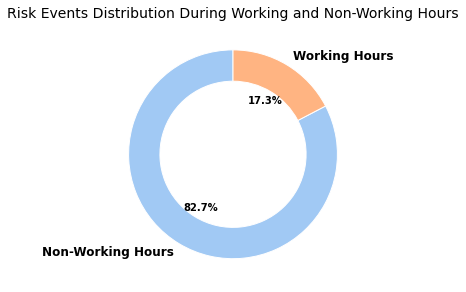

In [136]:
# Calculate the number and total number of risk events
risk_counts = data[data['at_risk_event'] == True].groupby('is_working_hour').size()
total_counts = data.groupby('is_working_hour').size()
risk_percentages = (risk_counts / total_counts) * 100

# Change the index to a more descriptive tag
risk_percentages.index = ['Non-Working Hours' if x == 0 else 'Working Hours' for x in risk_percentages.index]

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(aspect="equal"))
colors = sns.color_palette("pastel")[0:2]
wedges, texts, autotexts = ax.pie(risk_percentages, labels=risk_percentages.index, autopct='%1.1f%%',
                                  startangle=90, colors=colors, wedgeprops=dict(width=0.3, edgecolor='w'))
ax.set_title('Risk Events Distribution During Working and Non-Working Hours', fontsize=14)

for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('black')
    autotext.set_fontweight('bold')
plt.tight_layout()
plt.show()

However, we can clearly see that the proportion of risk events during non-working hours is very high.

Now, we want to see whether spending behavior and the occurrence of risk events differ significantly across **departments**.

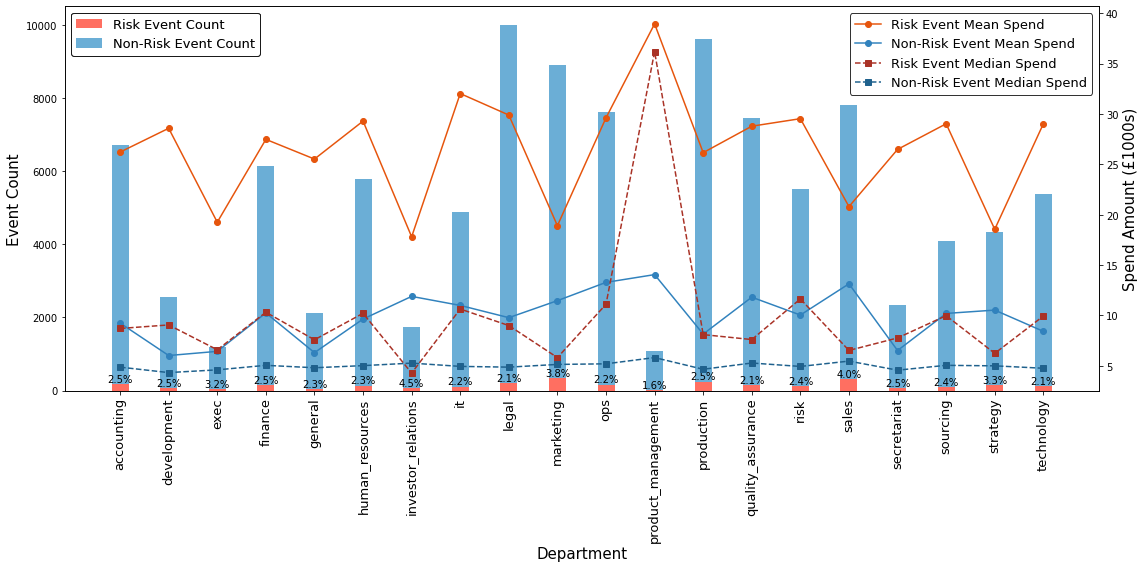

In [137]:
# Calculate the average expenditure of each department under risk events and non-risk events
mean_spend_risk = data[data['at_risk_event'] == True].groupby('department')['spend'].mean()
mean_spend_non_risk = data[data['at_risk_event'] == False].groupby('department')['spend'].mean()

# Calculate the median expenditure of each department under risk events and non-risk events
median_spend_risk = data[data['at_risk_event'] == True].groupby('department')['spend'].median()
median_spend_non_risk = data[data['at_risk_event'] == False].groupby('department')['spend'].median()

# Get the total and risk counts
risk_counts = data[data['at_risk_event'] == True].groupby('department').size()
total_counts = data.groupby('department').size()

# Get the proportion of risk event
risk_percentage = (risk_counts / total_counts) * 100

# Combine data
combined_data = pd.DataFrame({
    'total_count': total_counts,
    'risk_count': risk_counts,
    'non_risk_count': total_counts - risk_counts,
    'risk_percentage': risk_percentage
}).fillna(0)

# Set colors
bar_color_risk = '#FF6F61'
bar_color_non_risk = '#6BAED6'
line_color_mean_risk = '#E6550D'
line_color_mean_non_risk = '#3182BD'
line_color_median_risk = '#A93226'
line_color_median_non_risk = '#1F618D'

# Create the plot
fig, ax1 = plt.subplots(figsize=(16, 8))

departments = combined_data.index
total_count = combined_data['total_count'].values
risk_count = combined_data['risk_count'].values
non_risk_count = combined_data['non_risk_count'].values

bar_width = 0.35
bar1 = ax1.bar(departments, risk_count, bar_width, label='Risk Event Count', color=bar_color_risk)
bar2 = ax1.bar(departments, non_risk_count, bar_width, bottom=risk_count, label='Non-Risk Event Count', color=bar_color_non_risk)

# Add the proportion of risk event
for rect, percentage in zip(bar1, risk_percentage):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)

# Create a second y-axis
ax2 = ax1.twinx()

# Plot mean spend lines
line1, = ax2.plot(departments, mean_spend_risk, color=line_color_mean_risk, marker='o', label='Risk Event Mean Spend')
line2, = ax2.plot(departments, mean_spend_non_risk, color=line_color_mean_non_risk, marker='o', label='Non-Risk Event Mean Spend')

# Plot median spend lines
line3, = ax2.plot(departments, median_spend_risk, color=line_color_median_risk, marker='s', linestyle='--', label='Risk Event Median Spend')
line4, = ax2.plot(departments, median_spend_non_risk, color=line_color_median_non_risk, marker='s', linestyle='--', label='Non-Risk Event Median Spend')

# Set labels and titles
ax1.set_xlabel('Department', fontsize=15)
ax1.set_ylabel('Event Count', fontsize=15)
ax2.set_ylabel('Spend Amount (£1000s)', fontsize=15)
# ax1.set_title('Event Count and Risk Event Percentage per Department with Mean and Median Spend')

# Set x-axis labels
ax1.set_xticks(range(len(departments)))
ax1.set_xticklabels(departments, rotation=90,fontsize=13)

# Add legends
bar_legend = ax1.legend(loc='upper left', fontsize=13, frameon=True, facecolor='white', edgecolor='black')
line_legend = ax2.legend(loc='upper right', fontsize=13, frameon=True, facecolor='white', edgecolor='black')
ax1.add_artist(bar_legend)  # Add bar legend back after adding line legend

# Show the plot
plt.tight_layout()
plt.show()

We can use clustering to find department with high spend and department with low spend.

In [138]:
# Calculate the mean and median spend across each department
dept_stats = data.groupby('department').agg({
    'spend': ['median', 'mean']
}).reset_index()
dept_stats.columns = ['department', 'median_spend', 'mean_spend']

# K-means cluster using median and mean spend
features = ['median_spend', 'mean_spend']
kmeans = KMeans(n_clusters=2, random_state=0).fit(dept_stats[features])
dept_stats['cluster'] = kmeans.labels_

# Divide departments into high-spending and low-spending
cluster_median_spend = dept_stats.groupby('cluster')['median_spend'].mean()
high_spend_cluster = cluster_median_spend.idxmax()
low_spend_cluster = cluster_median_spend.idxmin()
high_spend_departments = dept_stats[dept_stats['cluster'] == high_spend_cluster]['department']
low_spend_departments = dept_stats[dept_stats['cluster'] == low_spend_cluster]['department']

# Add interactive variable from clustering result
data['is_high_spend_department_class'] = data['department'].apply(lambda x: 1 if x in high_spend_departments.values else 0)
data

/Users/jade/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,individual_id,date,day_of_week,hour_of_day,department,spend,at_risk_event,at_risk_behaviour_window,log_spend,hour,month,is_weekend,cluster_of_spend,is_high_spend,weekday_high_spend,weekend_high_spend,is_working_hour,high_spend_weekend_nonworking_hours,high_spend_weekday_working_hours,is_high_spend_department_class
0,1,2023-01-09,Monday,11.994438,ops,2.10,False,NaN,1.410987,12,1,0,0,0,0,0,1,0,0,1
1,1,2023-01-11,Wednesday,9.167461,ops,4.45,False,NaN,1.864080,9,1,0,0,0,0,0,1,0,0,1
2,1,2023-01-12,Thursday,8.863522,ops,3.94,False,NaN,1.781709,9,1,0,0,0,0,0,1,0,0,1
3,1,2023-01-12,Thursday,10.737514,ops,2.72,False,NaN,1.551809,11,1,0,0,0,0,0,1,0,0,1
4,1,2023-01-12,Thursday,13.516375,ops,1.50,False,NaN,1.252763,14,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105272,2184,2023-04-20,Thursday,12.349245,finance,8.91,False,NaN,2.389680,12,4,0,0,0,0,0,1,0,0,1
105273,2184,2023-04-21,Friday,10.207728,finance,20.24,False,NaN,3.101892,10,4,0,0,0,0,0,1,0,0,1
105274,2184,2023-04-24,Monday,17.414535,finance,12.25,False,NaN,2.656757,17,4,0,0,0,0,0,1,0,0,1
105275,2185,2023-02-08,Wednesday,12.837514,investor_relations,15.68,False,NaN,2.872434,13,2,0,0,0,0,0,1,0,0,1


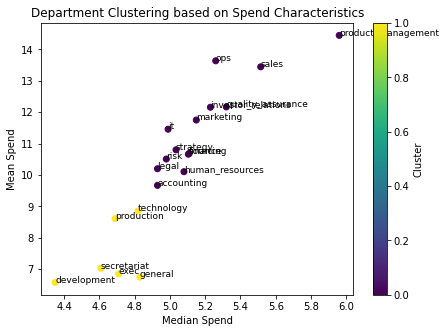

In [139]:
# Clustering Visualization
plt.figure(figsize=(7, 5))
plt.scatter(dept_stats['median_spend'], dept_stats['mean_spend'], c=dept_stats['cluster'], cmap='viridis', marker='o')
for i, dept in enumerate(dept_stats['department']):
    plt.text(dept_stats['median_spend'][i], dept_stats['mean_spend'][i], dept, fontsize=9)
plt.xlabel('Median Spend')
plt.ylabel('Mean Spend')
plt.title('Department Clustering based on Spend Characteristics')
plt.colorbar(label='Cluster')
plt.show()

In [140]:
high_spend_departments

0             accounting
3                finance
5        human_resources
6     investor_relations
7                     it
8                  legal
9              marketing
10                   ops
11    product_management
13     quality_assurance
14                  risk
15                 sales
17              sourcing
18              strategy
Name: department, dtype: object

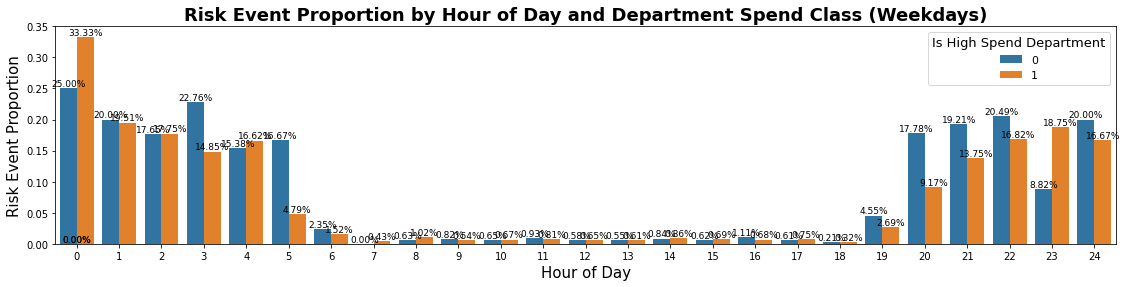

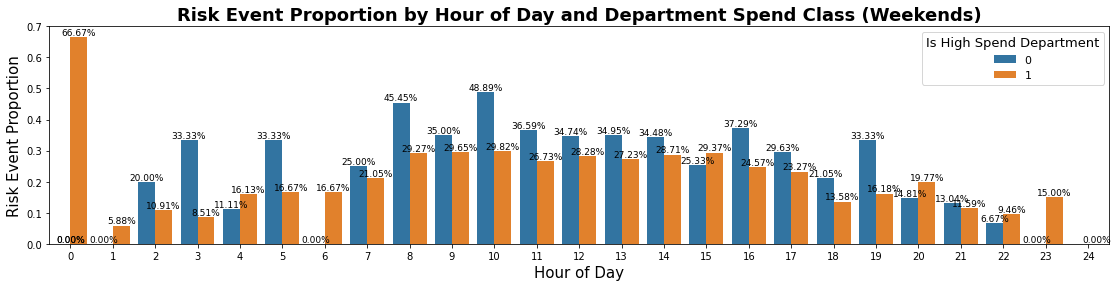

In [141]:
# Calculate the proportion of risk events for high and low spend departments at different times (hours, weekdays)
def calculate_risk_proportion(group):
    return group['at_risk_event'].mean()

# Group by hour, high spend department classification, and whether it's a weekend
hourly_risk_proportion_weekday = data[data['is_weekend'] == 0].groupby(['hour', 'is_high_spend_department_class']).apply(calculate_risk_proportion).reset_index()
hourly_risk_proportion_weekend = data[data['is_weekend'] == 1].groupby(['hour', 'is_high_spend_department_class']).apply(calculate_risk_proportion).reset_index()

hourly_risk_proportion_weekday.columns = ['hour', 'is_high_spend_department_class', 'risk_proportion']
hourly_risk_proportion_weekend.columns = ['hour', 'is_high_spend_department_class', 'risk_proportion']

# Plot risk event proportion by hour (Weekdays)
plt.figure(figsize=(19, 4))
barplot_weekday = sns.barplot(x='hour', y='risk_proportion', hue='is_high_spend_department_class', data=hourly_risk_proportion_weekday)
plt.title('Risk Event Proportion by Hour of Day and Department Spend Class (Weekdays)', fontsize=18, weight='bold')
plt.xlabel('Hour of Day', fontsize=15)
plt.ylabel('Risk Event Proportion', fontsize=15)
plt.legend(title='Is High Spend Department', title_fontsize='13', fontsize='11')

# Display percentage on each bar
for p in barplot_weekday.patches:
    height = p.get_height()
    barplot_weekday.annotate(f'{height:.2%}', (p.get_x() + p.get_width() / 2., height),
                             ha='center', va='bottom', fontsize=9)

plt.show()

# Plot risk event proportion by hour (Weekends)
plt.figure(figsize=(19, 4))
barplot_weekend = sns.barplot(x='hour', y='risk_proportion', hue='is_high_spend_department_class', data=hourly_risk_proportion_weekend)
plt.title('Risk Event Proportion by Hour of Day and Department Spend Class (Weekends)', fontsize=18, weight='bold')
plt.xlabel('Hour of Day', fontsize=15)
plt.ylabel('Risk Event Proportion', fontsize=15)
plt.legend(title='Is High Spend Department', title_fontsize='13', fontsize='11')

# Display percentage on each bar
for p in barplot_weekend.patches:
    height = p.get_height()
    barplot_weekend.annotate(f'{height:.2%}', (p.get_x() + p.get_width() / 2., height),
                             ha='center', va='bottom', fontsize=9)

plt.show()


In [142]:
# High spending department midweek at hours 0,23
data['high_spend_dep_weekday_certain_hour'] = ((data['is_high_spend_department_class'] == 1) & 
                                  (data['is_weekend'] == 0) & 
                                  (data['hour'].isin([0, 23]))).astype(int)

# Low spending department midweek at hours 3,20,21,22,24
data['low_spend_dep_weekday_certain_hour'] = ((data['is_high_spend_department_class'] == 0) & 
                                  (data['is_weekend'] == 0) & 
                                  (data['hour'].isin([3,20,21,22,24]))).astype(int)

# High spending department weekend at hours 0, 1, 20, 22, 23, 24
data['high_spend_dep_weekend_certain_hour'] = ((data['is_high_spend_department_class'] == 1) & 
                                  (data['is_weekend'] == 1) & 
                                  (data['hour'].isin([0, 1, 4, 20, 22, 23]))).astype(int)

# Low spending department weekends at hours 2,3,5,8,10,11,12,13,14,16,19
data['low_spend_dep_weekend_certain_hour'] = ((data['is_high_spend_department_class'] == 0) & 
                                       (data['is_weekend'] == 1) & 
                                       (data['hour'].isin([2,3,5,8,10,11,12,13,14,16,18,19]))).astype(int)
data


,individual_id,date,day_of_week,hour_of_day,department,spend,at_risk_event,at_risk_behaviour_window,log_spend,hour,...,weekday_high_spend,weekend_high_spend,is_working_hour,high_spend_weekend_nonworking_hours,high_spend_weekday_working_hours,is_high_spend_department_class,high_spend_dep_weekday_certain_hour,low_spend_dep_weekday_certain_hour,high_spend_dep_weekend_certain_hour,low_spend_dep_weekend_certain_hour
0,1,2023-01-09,Monday,11.994438,ops,2.10,False,NaN,1.410987,12,...,0,0,1,0,0,1,0,0,0,0
1,1,2023-01-11,Wednesday,9.167461,ops,4.45,False,NaN,1.864080,9,...,0,0,1,0,0,1,0,0,0,0
2,1,2023-01-12,Thursday,8.863522,ops,3.94,False,NaN,1.781709,9,...,0,0,1,0,0,1,0,0,0,0
3,1,2023-01-12,Thursday,10.737514,ops,2.72,False,NaN,1.551809,11,...,0,0,1,0,0,1,0,0,0,0
4,1,2023-01-12,Thursday,13.516375,ops,1.50,False,NaN,1.252763,14,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105272,2184,2023-04-20,Thursday,12.349245,finance,8.91,False,NaN,2.389680,12,...,0,0,1,0,0,1,0,0,0,0
105273,2184,2023-04-21,Friday,10.207728,finance,20.24,False,NaN,3.101892,10,...,0,0,1,0,0,1,0,0,0,0
105274,2184,2023-04-24,Monday,17.414535,finance,12.25,False,NaN,2.656757,17,...,0,0,1,0,0,1,0,0,0,0
105275,2185,2023-02-08,Wednesday,12.837514,investor_relations,15.68,False,NaN,2.872434,13,...,0,0,1,0,0,1,0,0,0,0


# Feature Engineering

### Rolling Window

In [143]:
# Calculate daily transaction count and daily average spend for each individual
daily_stats = data.groupby(['individual_id', data['date'].dt.date]).agg({
    'spend': ['count', 'mean']
}).reset_index()
daily_stats.columns = ['individual_id', 'date', 'daily_transactions', 'average_spend']

# Calculate each user's average daily transaction count and average daily spend
user_profiles = daily_stats.groupby('individual_id').agg({
    'daily_transactions': 'mean',
    'average_spend': 'mean'
})

# Define thresholds
freq_threshold = user_profiles['daily_transactions'].quantile(0.75)
spend_threshold = user_profiles['average_spend'].quantile(0.75)

# Classify users based on their transaction frequency and spending
user_profiles['type'] = np.where(
    (user_profiles['daily_transactions'] >= freq_threshold) & 
    (user_profiles['average_spend'] >= spend_threshold), 
    'High Frequency & High Spend', 
    np.where(
        (user_profiles['daily_transactions'] >= freq_threshold), 
        'High Frequency & Low Spend', 
        np.where(
            (user_profiles['average_spend'] >= spend_threshold), 
            'High Spend & Low Frequency', 
            'Low Frequency & Low Spend'
        )
    )
)

# Define window size based on user type
def select_window_size(user_type):
    if user_type == 'High Frequency & High Spend':
        return 3  
    elif user_type == 'High Frequency & Low Spend':
        return 5  
    elif user_type == 'High Spend & Low Frequency':
        return 7
    else:
        return 10

# Apply window size to each user
user_profiles['window_size'] = user_profiles['type'].apply(select_window_size)

# Merge window size back to the main data
data = pd.merge(data, user_profiles[['window_size']], left_on='individual_id', right_index=True, how='left')

# Calculate rolling statistics for each user
def calculate_rolling_statistics(group, window_size):
    group = group.sort_values('date')
    rolling_window = group['log_spend'].rolling(window=window_size, min_periods=1)
    group['rolling_mean_spend'] = rolling_window.mean()
    group['rolling_std_spend'] = rolling_window.std().fillna(0)  # Fill 0 values in standard deviation
    group['rolling_median_spend'] = rolling_window.median()
    group['rolling_mad_spend'] = rolling_window.apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
    group['z_score_spend'] = (group['log_spend'] - group['rolling_mean_spend']) / group['rolling_std_spend'].replace(0, np.nan)  # Prevent division by zero
    group['z_score_spend'] = group['z_score_spend'].fillna(0)  # Fill 0 values in z-score
    return group

# Apply rolling statistics calculation to each user's data
data = data.groupby('individual_id').apply(
    lambda group: calculate_rolling_statistics(group, group['window_size'].iloc[0])
).reset_index(drop=True)

# Drop the 'window_size' column as it's no longer needed
data.drop('window_size', axis=1, inplace=True)
data

,individual_id,date,day_of_week,hour_of_day,department,spend,at_risk_event,at_risk_behaviour_window,log_spend,hour,...,is_high_spend_department_class,high_spend_dep_weekday_certain_hour,low_spend_dep_weekday_certain_hour,high_spend_dep_weekend_certain_hour,low_spend_dep_weekend_certain_hour,rolling_mean_spend,rolling_std_spend,rolling_median_spend,rolling_mad_spend,z_score_spend
0,1,2023-01-09,Monday,11.994438,ops,2.10,False,NaN,1.410987,12,...,1,0,0,0,0,1.410987,0.000000,1.410987,0.000000,0.000000
1,1,2023-01-11,Wednesday,9.167461,ops,4.45,False,NaN,1.864080,9,...,1,0,0,0,0,1.637534,0.320385,1.637534,0.226547,0.707107
2,1,2023-01-12,Thursday,8.863522,ops,3.94,False,NaN,1.781709,9,...,1,0,0,0,0,1.685592,0.241355,1.781709,0.082371,0.398239
3,1,2023-01-12,Thursday,10.737514,ops,2.72,False,NaN,1.551809,11,...,1,0,0,0,0,1.652146,0.208109,1.666759,0.156136,-0.482139
4,1,2023-01-12,Thursday,13.516375,ops,1.50,False,NaN,1.252763,14,...,1,0,0,0,0,1.572270,0.253739,1.551809,0.229900,-1.259195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105272,2184,2023-04-20,Thursday,12.349245,finance,8.91,False,NaN,2.389680,12,...,1,0,0,0,0,2.090685,0.944264,2.222459,0.828693,0.316643
105273,2184,2023-04-21,Friday,10.207728,finance,20.24,False,NaN,3.101892,10,...,1,0,0,0,0,2.266572,1.050837,2.389680,0.995913,0.794909
105274,2184,2023-04-24,Monday,17.414535,finance,12.25,False,NaN,2.656757,17,...,1,0,0,0,0,2.110739,0.877565,2.389680,0.712213,0.622196
105275,2185,2023-02-08,Wednesday,12.837514,investor_relations,15.68,False,NaN,2.872434,13,...,1,0,0,0,0,2.872434,0.000000,2.872434,0.000000,0.000000


### Time Lag

In [144]:
# Add time lag
lag_features = ['log_spend']

# Lag time list
t_list = [1, 2, 3]
new_features = []

# Each lagging feature is treated according to individual_id
for feature in lag_features:
    for t in t_list:
        new_feature_name = f'{feature}_lag_{t}'
        data[new_feature_name] = data.groupby('individual_id')[feature].shift(t).fillna(0)
        new_features.append(feature)

data

,individual_id,date,day_of_week,hour_of_day,department,spend,at_risk_event,at_risk_behaviour_window,log_spend,hour,...,high_spend_dep_weekend_certain_hour,low_spend_dep_weekend_certain_hour,rolling_mean_spend,rolling_std_spend,rolling_median_spend,rolling_mad_spend,z_score_spend,log_spend_lag_1,log_spend_lag_2,log_spend_lag_3
0,1,2023-01-09,Monday,11.994438,ops,2.10,False,NaN,1.410987,12,...,0,0,1.410987,0.000000,1.410987,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2023-01-11,Wednesday,9.167461,ops,4.45,False,NaN,1.864080,9,...,0,0,1.637534,0.320385,1.637534,0.226547,0.707107,1.410987,0.000000,0.000000
2,1,2023-01-12,Thursday,8.863522,ops,3.94,False,NaN,1.781709,9,...,0,0,1.685592,0.241355,1.781709,0.082371,0.398239,1.864080,1.410987,0.000000
3,1,2023-01-12,Thursday,10.737514,ops,2.72,False,NaN,1.551809,11,...,0,0,1.652146,0.208109,1.666759,0.156136,-0.482139,1.781709,1.864080,1.410987
4,1,2023-01-12,Thursday,13.516375,ops,1.50,False,NaN,1.252763,14,...,0,0,1.572270,0.253739,1.551809,0.229900,-1.259195,1.551809,1.781709,1.864080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105272,2184,2023-04-20,Thursday,12.349245,finance,8.91,False,NaN,2.389680,12,...,0,0,2.090685,0.944264,2.222459,0.828693,0.316643,1.393766,1.011601,3.435921
105273,2184,2023-04-21,Friday,10.207728,finance,20.24,False,NaN,3.101892,10,...,0,0,2.266572,1.050837,2.389680,0.995913,0.794909,2.389680,1.393766,1.011601
105274,2184,2023-04-24,Monday,17.414535,finance,12.25,False,NaN,2.656757,17,...,0,0,2.110739,0.877565,2.389680,0.712213,0.622196,3.101892,2.389680,1.393766
105275,2185,2023-02-08,Wednesday,12.837514,investor_relations,15.68,False,NaN,2.872434,13,...,0,0,2.872434,0.000000,2.872434,0.000000,0.000000,0.000000,0.000000,0.000000


In [145]:
data.columns # the columns before processing

Index(['individual_id', 'date', 'day_of_week', 'hour_of_day', 'department',
       'spend', 'at_risk_event', 'at_risk_behaviour_window', 'log_spend',
       'hour', 'month', 'is_weekend', 'cluster_of_spend', 'is_high_spend',
       'weekday_high_spend', 'weekend_high_spend', 'is_working_hour',
       'high_spend_weekend_nonworking_hours',
       'high_spend_weekday_working_hours', 'is_high_spend_department_class',
       'high_spend_dep_weekday_certain_hour',
       'low_spend_dep_weekday_certain_hour',
       'high_spend_dep_weekend_certain_hour',
       'low_spend_dep_weekend_certain_hour', 'rolling_mean_spend',
       'rolling_std_spend', 'rolling_median_spend', 'rolling_mad_spend',
       'z_score_spend', 'log_spend_lag_1', 'log_spend_lag_2',
       'log_spend_lag_3'],
      dtype='object')

In [146]:
# categorical variables need to be encoded
encode_categorical_var = ['department','cluster_of_spend']
ordinal_categorical_var = ['day_of_week','month','hour']
# continuous variables
continuous_var = ['spend','log_spend','rolling_mean_spend',
       'rolling_std_spend', 'rolling_median_spend', 'rolling_mad_spend',
       'z_score_spend', 'log_spend_lag_1', 'log_spend_lag_2', 'log_spend_lag_3','hour_of_day']
# other categorical variables for modeling
categorical_var = ['is_weekend','is_working_hour','is_high_spend_department_class','is_high_spend',
                  'weekday_high_spend', 'weekend_high_spend','high_spend_weekend_nonworking_hours',
                   'high_spend_weekday_working_hours','high_spend_dep_weekday_certain_hour',
                   'low_spend_dep_weekday_certain_hour', 'high_spend_dep_weekend_certain_hour',
                   'low_spend_dep_weekend_certain_hour']

In [147]:
# the target
target1 = 'at_risk_event'
target2 = 'at_risk_behaviour_window'

In [148]:
# Preprocessing for ordinal categorical data
ordinal_transformer = OrdinalEncoder()
# Preprocessing for one-hot encoded categorical data
categorical_transformer = OneHotEncoder(drop = "first")
# Preprocessing for continuous data
continuous_transformer = StandardScaler()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ordinal_categorical_var),
        ('cat', categorical_transformer, encode_categorical_var),
        ('num', continuous_transformer, continuous_var)
    ],
    remainder= 'passthrough'  # Pass through the columns in `categorical_var` without any changes
)

# Apply preprocessing
X = data.drop(columns=[target1,target2, 'individual_id', 'date'],axis=1)  # Drop target and unnecessary columns
y_1 = data[target1] # we should not use it in modeling

# Fit and transform the data for the target1
X_processed_1 = preprocessor.fit_transform(X)

# Get feature names after encoding
ordinal_feature_names = [f'{col}_ord' for col in ordinal_categorical_var]
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(encode_categorical_var)
all_feature_names = ordinal_feature_names + list(encoded_feature_names) + continuous_var + categorical_var

# Convert the processed data back to a DataFrame
processed_data1 = pd.DataFrame(X_processed_1, columns=all_feature_names)

processed_data1

,day_of_week_ord,month_ord,hour_ord,department_development,department_exec,department_finance,department_general,department_human_resources,department_investor_relations,department_it,...,is_high_spend_department_class,is_high_spend,weekday_high_spend,weekend_high_spend,high_spend_weekend_nonworking_hours,high_spend_weekday_working_hours,high_spend_dep_weekday_certain_hour,low_spend_dep_weekday_certain_hour,high_spend_dep_weekend_certain_hour,low_spend_dep_weekend_certain_hour
0,1.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,6.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105272,4.0,3.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
105273,0.0,3.0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
105274,1.0,3.0,17.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
105275,6.0,1.0,13.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [149]:
processed_data1.columns # the features after processing

Index(['day_of_week_ord', 'month_ord', 'hour_ord', 'department_development',
       'department_exec', 'department_finance', 'department_general',
       'department_human_resources', 'department_investor_relations',
       'department_it', 'department_legal', 'department_marketing',
       'department_ops', 'department_product_management',
       'department_production', 'department_quality_assurance',
       'department_risk', 'department_sales', 'department_secretariat',
       'department_sourcing', 'department_strategy', 'department_technology',
       'cluster_of_spend_1', 'spend', 'log_spend', 'rolling_mean_spend',
       'rolling_std_spend', 'rolling_median_spend', 'rolling_mad_spend',
       'z_score_spend', 'log_spend_lag_1', 'log_spend_lag_2',
       'log_spend_lag_3', 'hour_of_day', 'is_weekend', 'is_working_hour',
       'is_high_spend_department_class', 'is_high_spend', 'weekday_high_spend',
       'weekend_high_spend', 'high_spend_weekend_nonworking_hours',
       'high_

### PCA

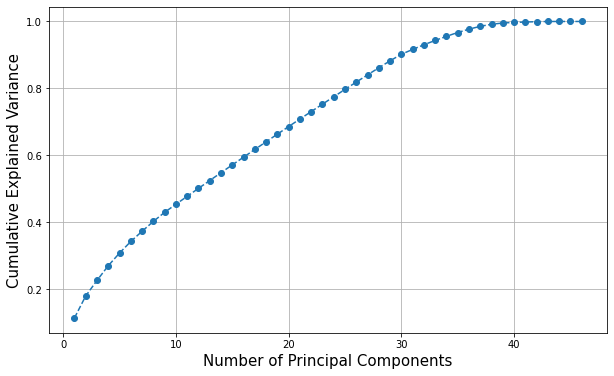

In [150]:
features = processed_data1 # data after feature processing
labels = y_1    # the data of target variable 'at_risk_event'

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# initialize PCA
pca = PCA()
pca.fit(scaled_features)

# Calculate the cumulative explanatory variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
# plt.title('Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components',fontsize=15)
plt.ylabel('Cumulative Explained Variance',fontsize=15)
plt.grid()
plt.show()

In [151]:
# Choose the number of principle component
n_components = 20

# Apply PCA algorithm
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_features)

# Convert it into a DataFrame
processed_data1_pca = pd.DataFrame(data=principal_components)
processed_data1_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-3.436262,0.649035,-1.223287,0.258913,-2.840115,0.396721,1.308531,-0.386322,-0.494885,-0.166611,1.035364,-0.135837,-0.903118,3.058993,1.377283,-0.636760,-0.697231,0.736993,0.394835,-0.399724
1,-2.285895,0.705316,-1.736678,-0.951766,-2.193729,-0.102717,0.080157,0.315077,-0.562060,-0.135026,1.149741,0.044229,-0.882952,2.968218,1.200818,-0.795249,-0.598600,0.840728,0.413002,0.153188
2,-1.743650,0.272972,-1.747050,-1.078888,-2.077077,-0.001948,1.060492,0.072116,-0.474682,-0.086875,1.021452,0.016101,-0.921297,2.928901,1.243792,-0.688752,-0.569184,0.810726,0.379630,-0.056601
3,-1.534918,-0.135754,-1.302914,-0.354096,-1.009529,-0.062562,1.586955,0.034918,-0.159958,-0.084058,1.032320,0.058941,-0.936875,2.922622,1.246526,-0.688609,-0.593976,0.757792,0.390012,-0.107340
4,-1.778306,-0.300483,-0.685762,0.783727,-0.190565,-0.084965,1.802260,-0.029347,0.103242,-0.135708,1.043931,0.042433,-0.920633,2.963446,1.291020,-0.686376,-0.653930,0.750796,0.411535,-0.115299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105272,0.272441,0.169535,-0.837136,0.038811,1.439570,-0.526422,-2.223505,0.678815,-0.115138,0.208635,0.973844,0.403996,-0.928231,-0.817975,-1.626995,2.285221,-1.855831,1.121580,0.034646,-0.283057
105273,0.877260,0.487192,-1.263560,-0.816519,0.955433,-0.401714,-3.169934,0.475389,-0.515351,0.108904,0.817084,0.181563,-0.904753,-0.729398,-1.480426,2.446344,-1.915791,1.173636,0.008093,-0.484856
105274,0.968115,-0.065395,0.251419,1.891694,0.833999,-0.427237,-1.727274,0.270887,0.273260,0.131757,0.744849,0.266325,-0.931771,-0.853730,-1.468316,2.484262,-1.869317,1.153984,-0.022374,-0.484638
105275,-0.761497,0.342248,-0.863727,0.260799,-3.413189,0.144072,0.885744,-0.380274,1.047050,-0.413647,-0.057219,0.122604,0.255354,0.619878,-0.133525,0.152757,-1.312611,-0.272917,0.574158,-1.183767


# Model

Now, we are ready to conduct modeling part after feature engineering, data preprocessing, and dimension reduction. 

In [152]:
features = processed_data1_pca
labels = y_1

### Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

Firstly, we would like to use a common and simple clustering anomaly detection algorithm.

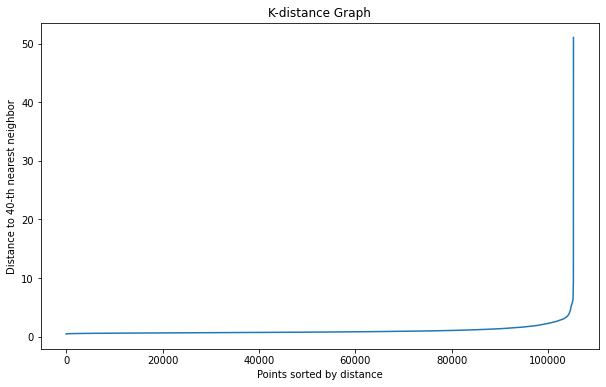

In [39]:
# Standardized features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# set min_samples with 2*dim, where dim=20
min_samples = 40

# Calculate K- distance
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)

# Plot the K-distance map to choose the parameter eps 
distances = np.sort(distances[:, min_samples-1], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to {}-th nearest neighbor'.format(min_samples))
plt.title('K-distance Graph')
plt.show()

We can tell the elbow point in this graoph is 2 that can be used as **eps**.

In [40]:
# Set the parameters in DBSCAN after K-distance plot
eps = 2  # Select the appropriate neighborhood radius using the K-distance plot
min_samples = 40  # Select the appropriate minimum number of samples

start_time = time.time()  # Start timing

# Clustering using DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
y_pred = dbscan.fit_predict(scaled_features)
# - 1 means anomalies's cluster
anomalies = (y_pred == -1).astype(int)

end_time = time.time()  # End timing
execution_time = end_time - start_time  # Calculat running time

# Calculate F1 values, Precision, and Recall
final_f1 = f1_score(labels, anomalies)
final_precision = precision_score(labels, anomalies)
final_recall = recall_score(labels, anomalies)

print(f"Final F1 Score: {final_f1}")
print(f"Final Precision: {final_precision}")
print(f"Final Recall: {final_recall}")
print(f"Execution time: {execution_time:.2f} seconds")
print(f"Global Anomalies Detected: {np.sum(anomalies)}")

Final F1 Score: 0.2583628796053646
Final Precision: 0.2255113024757804
Final Recall: 0.3024178996752075
Execution time: 18.92 seconds
Global Anomalies Detected: 3716


This is the code for detecting new input data points. 

In [ ]:
# # Get the core points
# core_samples_mask = np.zeros_like(labels, dtype=bool)
# core_samples_mask[dbscan.core_sample_indices_] = True
# core_points = scaled_features[core_samples_mask]

# # Build the nearest neighbor search tree
# nbrs = NearestNeighbors(n_neighbors=1).fit(core_points)

# # For new input data points
# new_point = np.array([...]) 
# # Standardization
# scaled_new_point = scaler.transform([new_point])
# pca_new_point = pca.transform(scaled_new_point)

# # Queries the nearest neighbor distance of a new data point
# distance, _ = nbrs.kneighbors(pca_new_point)
# is_anomaly = distance[0][0] > dbscan.eps # Check if it is a noise point

Additionally, to determine if new data points are anomalies, further steps are needed. We can extract cluster labels and core points from DBSCAN, use core points to build a nearest neighbor search tree, and calculate the distance of new data points to the nearest core point. If the distance is greater than Eps, the new data point is an anomaly.

### Isolation Forest (IF)

Then, we can try a tree-based model.

In [42]:
# Standardized features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Set the contamination value to 0.03
contamination_value = 0.03

start_time = time.time()  # Start timing

# Fit an Isolation Forest model
model = IsolationForest(contamination=contamination_value, n_estimators=100, max_samples=256, random_state=2)
model.fit(scaled_features)

y_pred = model.predict(scaled_features)
# -1 indicates an abnormal point,
anomalies = np.where(y_pred == -1, 1, 0)

end_time = time.time()  # End timing
execution_time = end_time - start_time  # Calculat running time

# Calculate F1 values, Precision, and Recall
final_f1 = f1_score(y_1, anomalies)
final_precision = precision_score(y_1, anomalies)
final_recall = recall_score(y_1, anomalies)

print(f"F1 Score: {final_f1}")
print(f"Precision: {final_precision}")
print(f"Recall: {final_recall}")
print(f"Execution time: {execution_time:.2f} seconds")
print(f"Global Anomalies Detected: {np.sum(anomalies)}")

F1 Score: 0.31602023608768964
Precision: 0.2966128521684077
Recall: 0.33814507398051247
Execution time: 4.35 seconds
Global Anomalies Detected: 3159


###  Bayesian Gaussian Mixture Model (BGMM)

In [160]:
# Standardized feature
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

start_time = time.time()  # Start timing

# Bayesian Gaussian mixture model was used to fit the data
bgmm = BayesianGaussianMixture( covariance_type='full', random_state=3)
bgmm.fit(scaled_features)

# Calculate the anomoly score for each data point
# Returns the log-likelihood score for each data point
# Note this is the negetive of log-likelihodd
anomaly_scores = - bgmm.score_samples(scaled_features)

# Set the threshold using 97% quantile and assume that 3% is abnormal
threshold = np.percentile(anomaly_scores, 97)
anomalies = anomaly_scores > threshold

end_time = time.time()  # End timing
execution_time = end_time - start_time  # Calculate running time

# Calculate F1 values, Precision, and Recall
f1 = f1_score(labels, anomalies, zero_division=0)
precision = precision_score(labels, anomalies, zero_division=0)
recall = recall_score(labels, anomalies, zero_division=0)

print("Overall Evaluation:")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Execution time: {execution_time:.2f} seconds")
print(f"Global Anomalies Detected: {np.sum(anomalies)}")

Overall Evaluation:
F1 Score: 0.3335581787521079
Precision: 0.313073757518202
Recall: 0.356910862504511
Execution time: 0.26 seconds
Global Anomalies Detected: 3159


### Robust Deep Autoencoder (RDA)

Before training the model, we first use **GridSearchCV** method to find the optimal paramters. Then, we can use the best parameter to train the model to detect anomalies. We set other parameters appropriately.

In [47]:
# Standardized feature
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# divid the dataset into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(scaled_features, labels, test_size=0.2, random_state=42)

# define a Robust Deep Autoencoder
def create_robust_autoencoder(encoding_dim1=15, encoding_dim2=9, encoding_dim3=3):
    input_layer = Input(shape=(scaled_features.shape[1],))
    
    # encoder
    encoder = Dense(encoding_dim1, activation="relu",
                    activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder = Dense(encoding_dim2, activation="relu")(encoder)
    encoder = Dense(encoding_dim3, activation="relu")(encoder)
    
    # decoder
    decoder = Dense(encoding_dim2, activation="relu")(encoder)
    decoder = Dense(encoding_dim1, activation="relu")(decoder)
    output_layer = Dense(scaled_features.shape[1], activation="sigmoid")(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer="adam", loss=Huber(delta=1.0))
    
    return autoencoder

# Use the KerasRegressor wrapper and pass custom parameters
autoencoder = KerasRegressor(model=create_robust_autoencoder, verbose=0, encoding_dim1=15, encoding_dim2=9, encoding_dim3=3, epochs=50, batch_size=32)

# Define a parameter grid
param_grid = {
    'encoding_dim1': [15, 18],
    'encoding_dim2': [9, 12],
    'encoding_dim3': [3, 6]
}

# Use GridSearchCV to find the optimal paramters
grid = GridSearchCV(estimator=autoencoder, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_result = grid.fit(X_train, X_train)

print(f"Best parameters: {grid_result.best_params_}")

Best parameters: {'encoding_dim1': 15, 'encoding_dim2': 12, 'encoding_dim3': 6}


In [52]:
start_time = time.time()  # Start timing

# Rebuild and train robust autoencoders using optimal parameters
best_autoencoder = create_robust_autoencoder(
    encoding_dim1=grid_result.best_params_['encoding_dim1'],
    encoding_dim2=grid_result.best_params_['encoding_dim2'],
    encoding_dim3=grid_result.best_params_['encoding_dim3']
)

best_autoencoder.summary() # Print the model structure

best_autoencoder.fit(X_train, X_train, 
                     epochs=100, 
                     batch_size=16, 
                     shuffle=True, 
                     validation_data=(X_val, X_val), 
                     verbose=1)

# Get the reconstructed data
reconstructed_features = best_autoencoder.predict(scaled_features)
reconstruction_errors = np.mean(np.abs(reconstructed_features - scaled_features), axis=1)

# Calculate the anomaly score
threshold = np.percentile(reconstruction_errors, 97)  # Set the threshold
anomalies = reconstruction_errors > threshold

end_time = time.time() # End timing
execution_time = end_time - start_time  # Get the running time

# Calculate F1 values, Precision, and Recall
f1 = f1_score(labels, anomalies, zero_division=0)
precision = precision_score(labels, anomalies, zero_division=0)
recall = recall_score(labels, anomalies, zero_division=0)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Execution time: {execution_time:.2f} seconds")
print(f"Global Anomalies Detected: {np.sum(anomalies)}")

Model: "model_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_126 (InputLayer)      [(None, 20)]              0         
                                                                 
 dense_550 (Dense)           (None, 15)                315       
                                                                 
 dense_551 (Dense)           (None, 12)                192       
                                                                 
 dense_552 (Dense)           (None, 6)                 78        
                                                                 
 dense_553 (Dense)           (None, 12)                84        
                                                                 
 dense_554 (Dense)           (None, 15)                195       
                                                                 
 dense_555 (Dense)           (None, 20)                320

# Target 2

In [161]:
data = pd.read_csv("edin_unit_data_v3.csv")
data = data.drop([data.columns[0]], axis=1) # drop the first column
data

,individual_id,timestamp,date,day_of_week,hour_of_day,department,spend,at_risk_event,at_risk_behaviour_window
0,1,59:40.0,09/01/2023,Monday,11.994438,ops,2.10,False,NaN
1,1,10:02.9,11/01/2023,Wednesday,9.167461,ops,4.45,False,NaN
2,1,51:48.7,12/01/2023,Thursday,8.863522,ops,3.94,False,NaN
3,1,44:15.0,12/01/2023,Thursday,10.737514,ops,2.72,False,NaN
4,1,30:58.9,12/01/2023,Thursday,13.516375,ops,1.50,False,NaN
...,...,...,...,...,...,...,...,...,...
105272,2184,20:57.3,20/04/2023,Thursday,12.349245,finance,8.91,False,NaN
105273,2184,12:27.8,21/04/2023,Friday,10.207728,finance,20.24,False,NaN
105274,2184,24:52.3,24/04/2023,Monday,17.414535,finance,12.25,False,NaN
105275,2185,50:15.0,08/02/2023,Wednesday,12.837514,investor_relations,15.68,False,NaN


In [162]:
# Convert date to datetime format
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
data['day_of_week'] = data['date'].dt.day_name().str[:3]

## Exploratory Data Analysis

Now, we want to randomly choose people and plot their behaviour windows.

In [163]:
# Sample a few individuals
sample_individuals = data['individual_id'].sample(3, random_state=1).unique()

# Filter data for the sampled individuals
sample_data = data[data['individual_id'].isin(sample_individuals)]

# Round hour_of_day to the nearest integer
sample_data['hour_of_day_rounded'] = sample_data['hour_of_day'].round()

<ipython-input-163-cb5d7cd0e332>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['hour_of_day_rounded'] = sample_data['hour_of_day'].round()


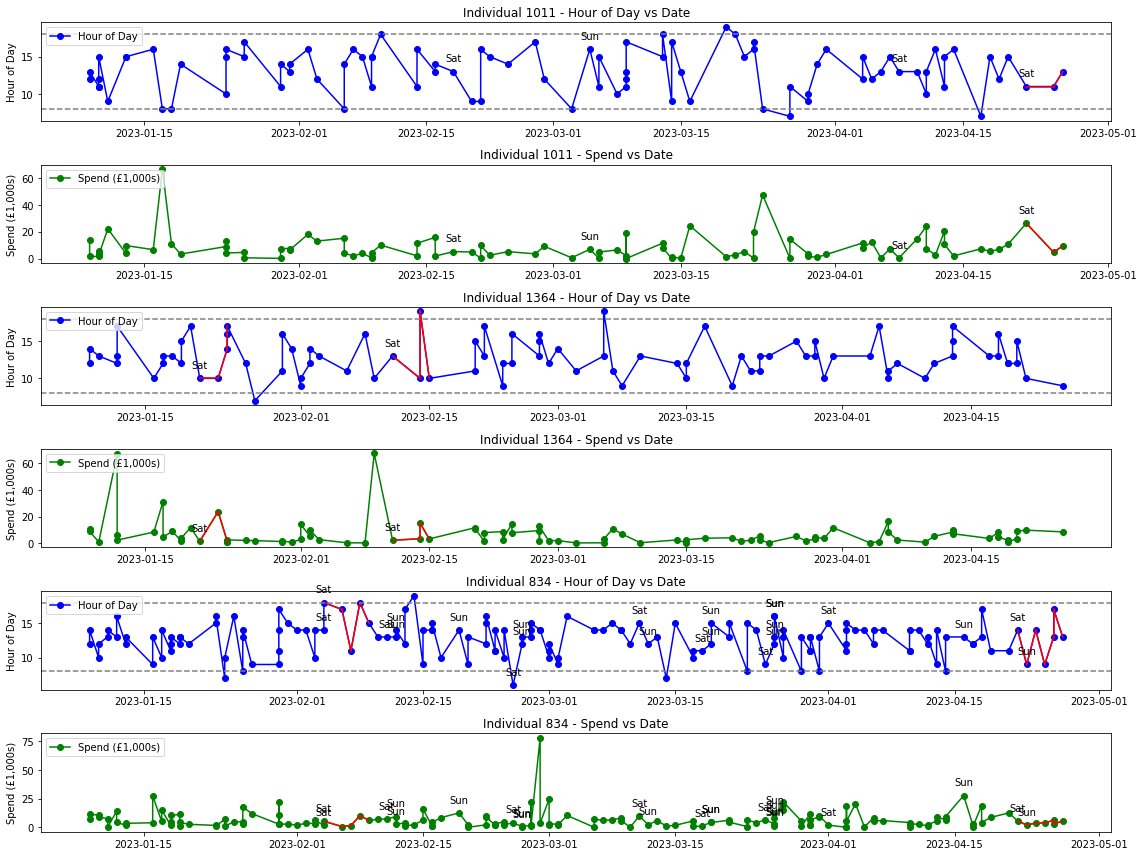

In [164]:
fig, axes = plt.subplots(2 * len(sample_individuals), 1, figsize=(16, 4 * len(sample_individuals)))

for i, individual in enumerate(sample_individuals):
    individual_data = sample_data[sample_data['individual_id'] == individual]
    risk_windows = individual_data['at_risk_behaviour_window'].notna()
    
    # Plotting hour_of_day vs date
    ax1 = axes[2 * i]
    ax1.plot(individual_data['date'], individual_data['hour_of_day_rounded'], marker='o', color='blue', label='Hour of Day')
    
    risk_data = individual_data[risk_windows]
    if len(risk_data) > 1:
        for j in range(len(risk_data) - 1):
            if risk_data['at_risk_behaviour_window'].iloc[j] == risk_data['at_risk_behaviour_window'].iloc[j + 1]:
                ax1.plot(risk_data['date'].iloc[j:j + 2], risk_data['hour_of_day_rounded'].iloc[j:j + 2], color='red')
    
    ax1.axhline(8, color='gray', linestyle='--')
    ax1.axhline(18, color='gray', linestyle='--')
    ax1.set_ylabel('Hour of Day')
    ax1.set_title(f'Individual {individual} - Hour of Day vs Date')
    ax1.legend(loc='upper left')
    
    # Annotate Saturdays and Sundays
    for idx, row in individual_data.iterrows():
        if row['date'].weekday() in [5, 6]:  # 5: Saturday, 6: Sunday
            ax1.annotate(row['day_of_week'], (row['date'], row['hour_of_day_rounded']), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Plotting spend vs date
    ax2 = axes[2 * i + 1]
    ax2.plot(individual_data['date'], individual_data['spend'], marker='o', color='green', label='Spend (£1,000s)')
    
    if len(risk_data) > 1:
        for j in range(len(risk_data) - 1):
            if risk_data['at_risk_behaviour_window'].iloc[j] == risk_data['at_risk_behaviour_window'].iloc[j + 1]:
                ax2.plot(risk_data['date'].iloc[j:j + 2], risk_data['spend'].iloc[j:j + 2], color='red')
    
    ax2.set_ylabel('Spend (£1,000s)')
    ax2.set_title(f'Individual {individual} - Spend vs Date')
    ax2.legend(loc='upper left')
    
    # Annotate Saturdays and Sundays
    for idx, row in individual_data.iterrows():
        if row['date'].weekday() in [5, 6]:  # 5: Saturday, 6: Sunday
            ax2.annotate(row['day_of_week'], (row['date'], row['spend']), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

In [165]:
data['day_of_week'] = data['date'].dt.dayofweek

In [166]:
# Individuals with risk behavior window
individuals_with_risk = data[data['at_risk_behaviour_window'].notna()]['individual_id'].unique()

# Set up counting variables
risk_windows_with_weekend = 0
second_risk_weekend_nonworkhours = 0

total_risk_windows = data['at_risk_behaviour_window'].nunique()

# Go through each person with risk behavior window
for individual in individuals_with_risk:
    individual_data = data[data['individual_id'] == individual]
    
    risk_windows = individual_data[individual_data['at_risk_behaviour_window'].notna()]['at_risk_behaviour_window'].unique() 
    
    for window in risk_windows:
        window_data = individual_data[individual_data['at_risk_behaviour_window'] == window]
        # Count the number of risk behavior window on weekends
        if any(window_data['day_of_week'].isin([5, 6])):
            risk_windows_with_weekend += 1

# Calculate the proportion
if total_risk_windows > 0:
    proportion = risk_windows_with_weekend / total_risk_windows
else:
    proportion = 0

print(f"The proportion of risk Windows that include weekends: {proportion:.2%}")

The proportion of risk Windows that include weekends: 65.24%


In [167]:
# Calculate Q1, Q3 and IQR for each department
department_quartiles = data.groupby('department')['spend'].quantile([0.25, 0.75]).unstack()
department_quartiles.columns = ['Q1', 'Q3']
department_quartiles['IQR'] = department_quartiles['Q3'] - department_quartiles['Q1']
# Merge departmental quartile data into the original data
data = pd.merge(data, department_quartiles, on='department', how='left')

# To define the high spend criteria
threshold_factor = 1.5
data['high_spend_threshold'] = data['Q3'] + threshold_factor * data['IQR']
# Add new variable
data['is_high_spend'] = data['spend'] > data['high_spend_threshold']

# Remove unnecessary columns
data = data.drop(columns=['Q1', 'Q3', 'IQR', 'high_spend_threshold'])

In [168]:
# Convert variables
data['is_weekend'] = data['day_of_week'].isin([5, 6])
data['is_working_hour'] = data['hour_of_day'].between(8, 18)

In [169]:
# Create a new column potential_risk_behaviour and initialize it to False
data['potential_risk_behaviour'] = False

for individual_id, group in data.groupby('individual_id'):
    has_high_spend = False
    has_weekend = False
    has_non_working_hour = False
    
    for idx, row in group.iterrows():
        # the current record meets one of the criteria for high spending, weekends, or non-working hours
        current_risk = row['is_high_spend'] or row['is_weekend'] or not row['is_working_hour']
        
        # Check for a previous condition of excessive expenses, weekends, or non-work time
        previous_risk = has_high_spend or has_weekend or has_non_working_hour
        
        if current_risk and previous_risk:
            data.at[idx, 'potential_risk_behaviour'] = True
        
        # Update condition status
        has_high_spend = has_high_spend or row['is_high_spend']
        has_weekend = has_weekend or row['is_weekend']
        has_non_working_hour = has_non_working_hour or not row['is_working_hour']

In [170]:
# Apply preprocessing
X = data.drop(columns=[target1,target2, 'individual_id', 'date','timestamp'],axis=1)  # Drop target and unnecessary columns
y_2 = data[target2] # we should not use it in modeling

In [171]:
ordinal_categorical_var = ['day_of_week']
encode_categorical_var =['department']
continuous_var = ['hour_of_day','spend']
categorical_var = ['is_high_spend','is_weekend','is_working_hour','potential_risk_behaviour']

In [172]:
# Preprocessing for ordinal categorical data
ordinal_transformer = OrdinalEncoder()
# Preprocessing for one-hot encoded categorical data
categorical_transformer = OneHotEncoder(drop = "first")
# Preprocessing for continuous data
continuous_transformer = StandardScaler()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ordinal_categorical_var),
        ('cat', categorical_transformer, encode_categorical_var),
        ('num', continuous_transformer, continuous_var)
    ],
    remainder= 'passthrough'  # Pass through the columns in `categorical_var` without any changes
)


# Fit and transform the data for the target1
X_processed_2 = preprocessor.fit_transform(X)

# Get feature names after encoding
ordinal_feature_names = [f'{col}_ord' for col in ordinal_categorical_var]
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(encode_categorical_var)
all_feature_names = ordinal_feature_names + list(encoded_feature_names) + continuous_var + categorical_var

# Convert the processed data back to a DataFrame
processed_data2 = pd.DataFrame(X_processed_2, columns=all_feature_names)

processed_data2

,day_of_week_ord,department_development,department_exec,department_finance,department_general,department_human_resources,department_investor_relations,department_it,department_legal,department_marketing,...,department_secretariat,department_sourcing,department_strategy,department_technology,hour_of_day,spend,is_high_spend,is_weekend,is_working_hour,potential_risk_behaviour
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.333957,-0.464553,0.0,0.0,1.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.242320,-0.337078,0.0,0.0,1.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.339982,-0.364743,0.0,0.0,1.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.737831,-0.430921,0.0,0.0,1.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.155071,-0.497099,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105272,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.219950,-0.095148,0.0,0.0,1.0,0.0
105273,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.908062,0.519442,0.0,0.0,1.0,0.0
105274,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.407627,0.086028,0.0,0.0,1.0,0.0
105275,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.063060,0.272087,0.0,0.0,1.0,0.0


## Evaluation Function

In [173]:
def second_target_eval_func(df,
                            second_target_pred_col_name="second_target_pred",
                            at_risk_behaviour_window_col_name="at_risk_behaviour_window"):
    """
    Evaluate the predictions for the second target, at_risk_behaviour_window.

    Args:
        df (pandas.DataFrame): the dataframe with your predictions and the target window.
        second_target_pred_col_name (string): the name of the column with your predictions.
        at_risk_behaviour_window_col_name (string): the name of the column with the target window.

    Returns:
        pandas.DataFrame: the original dataframe with 2 additional columns:
            target_window_found: has value True if window found, False if window wasnt found, NaN if event isnt in a window;
            correct_predictions: has value True if prediction was in a window, False if outside, NaN if no prediction made.
        float: precision.
        float: recall.
    """

    df_copy = df.copy()

    # Identify the windows found.
    windows_found = df_copy.groupby(at_risk_behaviour_window_col_name).agg({second_target_pred_col_name:"max"})[second_target_pred_col_name]
    windows_missed = ~windows_found

    # Join the windows found with the df.
    df_copy = pd.merge(df_copy, pd.DataFrame(windows_found), left_on=at_risk_behaviour_window_col_name, right_index=True, how="left", suffixes=("", "_found"))
    df_copy = df_copy.rename(columns={second_target_pred_col_name + "_found":"target_window_found"})

    # Identify the events where a prediction was correctly or incorrectly made.
    correct_predictions = df_copy[df_copy[second_target_pred_col_name]][at_risk_behaviour_window_col_name].notna()
    df_copy["correct_predictions"] = correct_predictions
    num_predictions = sum(df_copy[second_target_pred_col_name])
    missed_predictions = (correct_predictions == False).sum()

    # Calculate metrics.
    """
    TP is the number of windows correctly identified.
    FP is the number of predictions made incorrectly.
    Additional predictions made for a window after the first do not affect the precision or recall (ie the FP wont change).
    """
    TP = windows_found.sum()
    FP = missed_predictions
    support = len(windows_found)
    precision = TP/(TP + FP)
    recall = TP/support

    return df_copy, precision, recall

We first try a BGMM model for this task.

In [112]:
# Standardized feature
scaler = StandardScaler()
scaled_features = scaler.fit_transform(processed_data2)

# Bayesian Gaussian mixture model was used to fit the data
bgmm = BayesianGaussianMixture( covariance_type='full', random_state=0)
bgmm.fit(scaled_features)

# Calculate the anomoly score for each data point
# Returns the log-likelihood score for each data point
# Note this is the negetive of log-likelihodd
anomaly_scores = - bgmm.score_samples(scaled_features)

# Set the threshold using 97% quantile and assume that 3% is abnormal
threshold = np.percentile(anomaly_scores, 97)
anomalies = anomaly_scores > threshold

# Save the result
result = pd.DataFrame(anomalies, columns=['risk_behaviour_start'])

# Merge abnormal results into the original data
data_with_risk_behaviour = pd.concat([data.reset_index(drop=True), result], axis=1)
data_with_risk_behaviour

,individual_id,timestamp,date,day_of_week,hour_of_day,department,spend,at_risk_event,at_risk_behaviour_window,is_high_spend,is_weekend,is_working_hour,potential_risk_behaviour,risk_behaviour_start
0,1,59:40.0,2023-01-09,0,11.994438,ops,2.10,False,NaN,False,False,True,False,False
1,1,10:02.9,2023-01-11,2,9.167461,ops,4.45,False,NaN,False,False,True,False,False
2,1,51:48.7,2023-01-12,3,8.863522,ops,3.94,False,NaN,False,False,True,False,False
3,1,44:15.0,2023-01-12,3,10.737514,ops,2.72,False,NaN,False,False,True,False,False
4,1,30:58.9,2023-01-12,3,13.516375,ops,1.50,False,NaN,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105272,2184,20:57.3,2023-04-20,3,12.349245,finance,8.91,False,NaN,False,False,True,False,False
105273,2184,12:27.8,2023-04-21,4,10.207728,finance,20.24,False,NaN,False,False,True,False,False
105274,2184,24:52.3,2023-04-24,0,17.414535,finance,12.25,False,NaN,False,False,True,False,False
105275,2185,50:15.0,2023-02-08,2,12.837514,investor_relations,15.68,False,NaN,False,False,True,False,False


In [114]:
df_with_pred_evaluations, precision, recall = second_target_eval_func(df=data_with_risk_behaviour,
                                                                      second_target_pred_col_name="risk_behaviour_start")

In [115]:
print("precision:", precision, "recall:", recall)

precision: 0.030333333333333334 recall: 0.1001100110011001


In [117]:
f1 = 2*precision*recall / (precision+recall)
print("F1-Score:", f1)

F1-Score: 0.04655922230749552


Next, we want to try RDA model here.

In [175]:
# Standardized feature
scaler = StandardScaler()
scaled_features = scaler.fit_transform(processed_data2)

# divid the dataset into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(scaled_features, labels, test_size=0.2, random_state=42)

# define a Robust Deep Autoencoder
def create_robust_autoencoder(encoding_dim1=15, encoding_dim2=9, encoding_dim3=3):
    input_layer = Input(shape=(scaled_features.shape[1],))
    
    # encoder
    encoder = Dense(encoding_dim1, activation="relu",
                    activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder = Dense(encoding_dim2, activation="relu")(encoder)
    encoder = Dense(encoding_dim3, activation="relu")(encoder)
    
    # decoder
    decoder = Dense(encoding_dim2, activation="relu")(encoder)
    decoder = Dense(encoding_dim1, activation="relu")(decoder)
    output_layer = Dense(scaled_features.shape[1], activation="sigmoid")(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer="adam", loss=Huber(delta=1.0))
    
    return autoencoder

# Rebuild and train robust autoencoders using optimal parameters
best_autoencoder = create_robust_autoencoder(
    encoding_dim1=15,
    encoding_dim2=12,
    encoding_dim3=6
)

best_autoencoder.summary() # Print the model structure

best_autoencoder.fit(X_train, X_train, 
                     epochs=100, 
                     batch_size=16, 
                     shuffle=True, 
                     validation_data=(X_val, X_val), 
                     verbose=1)

# Get the reconstructed data
reconstructed_features = best_autoencoder.predict(scaled_features)
reconstruction_errors = np.mean(np.abs(reconstructed_features - scaled_features), axis=1)

# Calculate the anomaly score
threshold = np.percentile(reconstruction_errors, 97)  # Set the threshold
anomalies = reconstruction_errors > threshold

# Save the result from RDA model
result = pd.DataFrame(anomalies, columns=['risk_behaviour_start'])

# Merge data
data_with_risk_behaviour = pd.concat([data.reset_index(drop=True), result], axis=1)
data_with_risk_behaviour

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense (Dense)               (None, 15)                405       
                                                                 
 dense_1 (Dense)             (None, 12)                192       
                                                                 
 dense_2 (Dense)             (None, 6)                 78        
                                                                 
 dense_3 (Dense)             (None, 12)                84        
                                                                 
 dense_4 (Dense)             (None, 15)                195       
                                                                 
 dense_5 (Dense)             (None, 26)                416   

5264/5264 [==============================] - 6s 1ms/step - loss: 0.2235 - val_loss: 0.2221
Epoch 67/100
5264/5264 [==============================] - 6s 1ms/step - loss: 0.2235 - val_loss: 0.2221
Epoch 68/100
5264/5264 [==============================] - 7s 1ms/step - loss: 0.2235 - val_loss: 0.2221
Epoch 69/100
5264/5264 [==============================] - 6s 1ms/step - loss: 0.2235 - val_loss: 0.2221
Epoch 70/100
5264/5264 [==============================] - 6s 1ms/step - loss: 0.2235 - val_loss: 0.2221
Epoch 71/100
5264/5264 [==============================] - 6s 1ms/step - loss: 0.2235 - val_loss: 0.2221
Epoch 72/100
5264/5264 [==============================] - 7s 1ms/step - loss: 0.2236 - val_loss: 0.2222
Epoch 73/100
5264/5264 [==============================] - 6s 1ms/step - loss: 0.2235 - val_loss: 0.2221
Epoch 74/100
5264/5264 [==============================] - 6s 1ms/step - loss: 0.2235 - val_loss: 0.2222
Epoch 75/100
5264/5264 [==============================] - 6s 1ms/step - loss:

,individual_id,timestamp,date,day_of_week,hour_of_day,department,spend,at_risk_event,at_risk_behaviour_window,is_high_spend,is_weekend,is_working_hour,potential_risk_behaviour,risk_behaviour_start
0,1,59:40.0,2023-01-09,0,11.994438,ops,2.10,False,NaN,False,False,True,False,False
1,1,10:02.9,2023-01-11,2,9.167461,ops,4.45,False,NaN,False,False,True,False,False
2,1,51:48.7,2023-01-12,3,8.863522,ops,3.94,False,NaN,False,False,True,False,False
3,1,44:15.0,2023-01-12,3,10.737514,ops,2.72,False,NaN,False,False,True,False,False
4,1,30:58.9,2023-01-12,3,13.516375,ops,1.50,False,NaN,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105272,2184,20:57.3,2023-04-20,3,12.349245,finance,8.91,False,NaN,False,False,True,False,False
105273,2184,12:27.8,2023-04-21,4,10.207728,finance,20.24,False,NaN,False,False,True,False,False
105274,2184,24:52.3,2023-04-24,0,17.414535,finance,12.25,False,NaN,False,False,True,False,False
105275,2185,50:15.0,2023-02-08,2,12.837514,investor_relations,15.68,False,NaN,False,False,True,False,False


In [176]:
df_with_pred_evaluations, precision, recall = second_target_eval_func(df=data_with_risk_behaviour,
                                                                      second_target_pred_col_name="risk_behaviour_start")

In [178]:
f1 = 2*precision*recall / (precision+recall)
print("F1-Score:", f1, "precision:", precision, "recall:", recall)

F1-Score: 0.08278976417461113 precision: 0.05362365940851479 recall: 0.18151815181518152


For task 2, we found that the normal point anomaly detection method is not suitable here.  It is more appropriate to use different time series models for different individuals to capture the characteristics of risky behaviors.